<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install httpx

     |████████████████████████████████| 84 kB 1.1 MB/s 
     |████████████████████████████████| 68 kB 2.1 MB/s 
     |████████████████████████████████| 79 kB 4.1 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 


In [2]:
from numpy.testing._private.utils import import_nose
import pandas as pd
import itertools
from scipy.fft import fft, ifft, rfft, irfft, rfftfreq
from tqdm.notebook import tqdm
import json
from collections import defaultdict
import pickle
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
from datetime import date, timedelta
import pickle
import httpx
import json
import warnings
# warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# def get_df():
# #   import httpx
#   data = httpx.get("https://storage.yandexcloud.net/covid-19/people_structure.csv").content
#   return pd.read_csv(data)

def get_cases(days):
  data = httpx.get(f"https://storage.yandexcloud.net/covid-19/cases{\
      ('_' + str(days)) if days != 0 else ''}.pickle").content
  return pickle.loads(data)

In [4]:
path = "https://storage.yandexcloud.net/covid-19/people_structure.csv"
data = pd.read_csv(path)
data.sample(10)

,Unnamed: 0,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
141683,146113,Turkey,2020-06-20,186493.0,1248.0,1402.286,4927.0,22.0,19.286,2192.933,14.675,16.489,57.936,0.259,0.227,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41112.0,2864454.0,33.683,0.483,45393.0,0.534,0.0309,32.4,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.89,85042736.0,104.914,31.6,8.153,5.061,25129.341,0.2,171.285,12.13,14.1,41.1,NaN,2.81,77.69,0.820,NaN,NaN,NaN,NaN
63649,66623,Iceland,2021-09-08,11130.0,40.0,39.143,33.0,0.0,0.000,30179.613,108.462,106.138,89.481,0.000,0.000,0.75,NaN,NaN,7.0,18.981,NaN,NaN,NaN,NaN,2008.0,604863.0,1640.120,5.445,2233.0,6.055,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,568.0,NaN,NaN,NaN,NaN,1540.0,101.0,0.027,32.41,368792.0,3.404,37.3,14.431,9.207,46482.958,0.2,117.992,5.31,14.3,15.2,NaN,2.91,82.99,0.949,NaN,NaN,NaN,NaN
98008,102438,Netherlands,2020-06-21,49670.0,91.0,115.714,6105.0,1.0,4.429,2892.315,5.299,6.738,355.498,0.058,0.258,0.64,55.0,3.203,221.0,12.869,NaN,NaN,NaN,NaN,4285.0,167671.0,9.764,0.250,8809.0,0.513,0.0131,76.1,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.26,17173094.0,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.944,6191.3,7.99,-0.06,360.523270
142492,146922,Turks and Caicos Islands,2020-04-29,12.0,0.0,0.143,1.0,0.0,0.000,305.920,0.000,3.642,25.493,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39226.0,37.312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.22,NaN,NaN,NaN,NaN,NaN
23644,24388,Burundi,2021-08-11,9175.0,375.0,236.714,38.0,0.0,0.000,748.648,30.599,19.315,3.101,0.000,0.000,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.74,12255429.0,423.062,17.5,2.562,1.504,702.225,71.7,293.068,6.05,NaN,NaN,6.144,0.80,61.58,0.433,NaN,NaN,NaN,NaN
34818,35562,Cuba,2020-10-03,5780.0,62.0,52.571,122.0,0.0,0.286,510.714,5.478,4.645,10.780,0.000,0.025,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7538.0,643701.0,56.877,0.666,7397.0,0.654,0.0071,140.7,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.15,11317498.0,110.408,43.1,14.738,9.719,NaN,NaN,190.968,8.27,17.1,53.3,85.198,5.20,78.80,0.783,NaN,NaN,NaN,NaN
121220,125650,Saudi Arabia,2021-10-31,548617.0,46.0,52.143,8794.0,1.0,2.286,15523.668,1.302,1.475,248.835,0.028,0.065,0.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39750.0,30389463.0,859.900,1.125,41937.0,1.187,0.0012,804.3,tests performed,45720862.0,24208729.0,21512133.0,NaN,79329.0,64860.0,129.37,68.5,60.87,NaN,1835.0,17741.0,0.050,61.11,35340680.0,15.322

In [5]:
def change_col_name(df):
    df.columns = ['date', 'country', 'new_cases_sm', 'fully_vaccinated']
    return df

In [6]:
df =\
(data
 .loc[: , ['date', 'location', 'new_cases_smoothed', 'people_fully_vaccinated']]
 .loc[data['location'] == 'Russia', :]
 .dropna()
 .pipe(change_col_name)
 .assign(date = pd.to_datetime(data['date']).dt.date)
 .reset_index()
 .set_index('date')
 .sort_index(ascending=True)
 .drop('index', axis=1)
)
df

,country,new_cases_sm,fully_vaccinated
date,,,
2021-03-02,Russia,11166.429,1091497.0
2021-03-03,Russia,10996.000,1201919.0
2021-03-04,Russia,11024.000,1309569.0
2021-03-05,Russia,11017.000,1393676.0
2021-03-06,Russia,10945.571,1501746.0
...,...,...,...
2022-01-29,Russia,80887.143,69581579.0
2022-01-30,Russia,89119.857,69704859.0
2022-01-31,Russia,97477.000,69815128.0


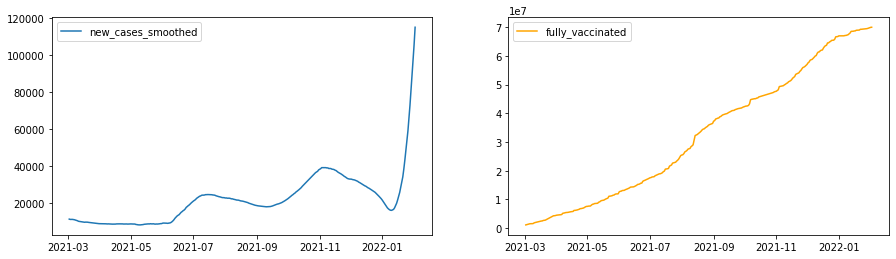

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
ax1, ax2 = axs
ax1.plot(df['new_cases_sm']);
ax1.legend(loc='best', labels=['new_cases_smoothed']);
ax2.plot(df['fully_vaccinated'], color='orange');
ax2.legend(loc='best', labels=['fully_vaccinated']);

In [8]:
# cases = df['new_cases_sm'].values
cases = get_cases(60)['Russia']['history']

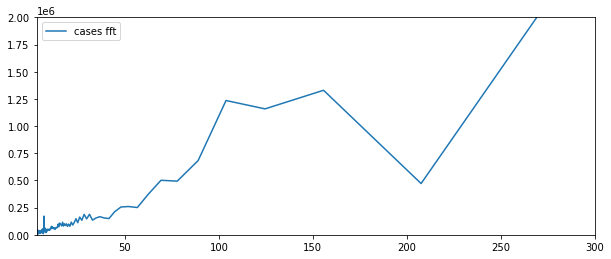

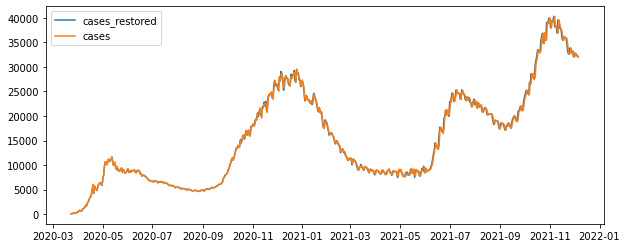

In [9]:
x = cases.index
y = cases.values
n = cases.shape[0]

cases_rfft = rfft(y) #[1:]
cases_freq = rfftfreq(n=n, d=1)
cases_freq[0] = 1/36500 # 1 цикл в 100 лет - просто некоторый большой период
cases_period = 1 / cases_freq
# print(cases_period.shape)
# cases_fft
# assert(cases_rfft.shape == x[1:].shape)
# cases_rfft[np.abs(cases_period - 7) <= 5] *= 0

plt.figure(figsize=(10, 4))
plt.plot(cases_period, np.abs(cases_rfft));
ax = plt.gca()
ax.set_ylim((0, 2e6))
ax.set_xlim((3, 300))
ax.legend(loc='upper left', labels=['cases fft'])
plt.show();

plt.figure(figsize=(10, 4))

cases_rest = irfft(cases_rfft[:])
plt.plot(x[:cases_rest.shape[0]], cases_rest, label='cases_restored');

plt.plot(x, y, label='cases');
plt.legend(loc='best');

# plt.xticks(pd.date_range(start="2020-04-01", end="2022-02-01", periods=5));


((1, 312), (1, 312), (1, 3), (623, 1))

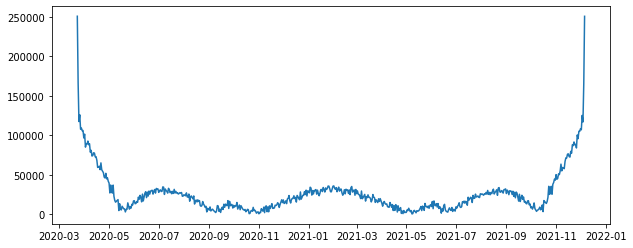

In [23]:
cases_ampls = np.abs(cases_rfft).reshape(1, -1) / n
cases_phases = np.angle(cases_rfft).reshape(1, -1)
cases_freq = cases_freq.reshape(1, -1)

t = np.asarray([d.days for d in x - x[0]]).reshape(-1, 1)

cases_ampls = np.asarray((list(cases_ampls[:: -1]) + [0] + list(cases_ampls)))
cases_freq = np.asarray((list(-cases_freq[:: -1]) + [0] + list(cases_freq)))

# cases_harm = np.abs((cases_ampls*np.exp(t @ cases_freq * 2j * np.pi + cases_phases)).sum(axis=1))

plt.figure(figsize=(10, 4));
plt.plot(x, cases_harm);
cases_ampls.shape, cases_phases.shape, cases_freq.shape, t.shape




In [27]:
cases_ampls[:: -1]

array([[1.54573499e+04, 2.15203590e+03, 4.89416989e+03, 7.57042196e+02,
        2.13367252e+03, 1.85908957e+03, 1.98263402e+03, 1.09647421e+03,
        7.92141576e+02, 8.04889839e+02, 5.94045120e+02, 4.02646250e+02,
        4.17393181e+02, 4.10598111e+02, 3.39265262e+02, 2.39627903e+02,
        2.49276621e+02, 2.67406226e+02, 2.48126663e+02, 2.16701463e+02,
        3.02847008e+02, 2.35050267e+02, 3.01163757e+02, 2.14700594e+02,
        2.61318981e+02, 1.78861061e+02, 2.37594473e+02, 1.83466153e+02,
        1.43871863e+02, 1.86867140e+02, 1.26663023e+02, 1.57526225e+02,
        1.23640953e+02, 1.62251673e+02, 1.37332024e+02, 1.62897006e+02,
        1.30023438e+02, 1.85677171e+02, 1.30958706e+02, 1.47853974e+02,
        1.63715479e+02, 1.72982099e+02, 1.20141636e+02, 1.56829006e+02,
        1.11740639e+02, 1.03509426e+02, 1.10206766e+02, 1.06338066e+02,
        8.22779086e+01, 8.57008960e+01, 1.03338961e+02, 8.84554320e+01,
        9.45323402e+01, 9.73446397e+01, 1.15454856e+02, 1.075603

In [15]:
# (t @ cases_freq).shape
# t.shape, cases_freq.shape

ValueError: ignored

In [12]:
fft_ = fft(cases)[:]
x = df['new_cases_sm'].index

plt.plot(x, fft_);

ax = plt.gca()
ax.set_ylim((0, 0.6e6))
# ax.set_xlim((0, 0.5))
plt.show();

plt.plot(x, ifft(fft_))

KeyError: ignored